## 03 - Neural Networks

In this notebook we implement an approach based on neural networks, using the **MLPClassifier** from scikit-learn to predict whether the tweets refer to a real disaster or not. We use the tweets after cleaning (see approach 02).

#### Loading data

We start by importing the packages we are going to use:

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import string
from nltk import download
from nltk.corpus import stopwords
download('stopwords')

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn import metrics

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.neural_network import MLPClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/athena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We load the datasets:

In [2]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

# We drop for now the keyword and location information
train_data = train_data.drop(['id', 'keyword', 'location'], axis=1)
test_data = test_data.drop(['keyword', 'location'], axis=1)

train_data

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


#### Exploratory Data Analysis

In [3]:
train_data.describe(include='all')

,text,target
count,7613,7613.00000
unique,7503,NaN
top,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,10,NaN
mean,NaN,0.42966
std,NaN,0.49506
min,NaN,0.00000
25%,NaN,0.00000
50%,NaN,0.00000
75%,NaN,1.00000


In [4]:
train_data.groupby('target').describe()

text                                                               
       count unique                                                top freq
target                                                                     
0       4342   4315  He came to a land which was engulfed in tribal...    4
1       3271   3206  11-Year-Old Boy Charged With Manslaughter of T...   10

We now want to create some new features which might be useful to predict the target variable. We start with the length of the tweet:

In [5]:
train_data['text_len'] = train_data['text'].apply(len)
test_data['text_len'] = test_data['text'].apply(len)

train_data

,text,target,text_len
0,Our Deeds are the Reason of this #earthquake M...,1,69
1,Forest fire near La Ronge Sask. Canada,1,38
2,All residents asked to 'shelter in place' are ...,1,133
3,"13,000 people receive #wildfires evacuation or...",1,65
4,Just got sent this photo from Ruby #Alaska as ...,1,88
...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,83
7609,@aria_ahrary @TheTawniest The out of control w...,1,125
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65
7611,Police investigating after an e-bike collided ...,1,137


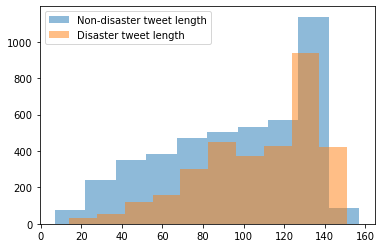

In [6]:
fig, ax = plt.subplots()

disaster_text_lens = train_data.loc[train_data['target'] == 1, 'text_len']
non_disaster_text_lens = train_data.loc[train_data['target'] == 0, 'text_len']

ax.hist(non_disaster_text_lens, label='Non-disaster tweet length', alpha=0.5, color='tab:blue')
ax.hist(disaster_text_lens, label='Disaster tweet length', alpha=0.5, color='tab:orange')

plt.legend()

In [7]:
disaster_text_lens.describe()

count    3271.000000
mean      108.113421
std        29.309854
min        14.000000
25%        88.000000
50%       115.000000
75%       136.000000
max       151.000000
Name: text_len, dtype: float64

In [8]:
non_disaster_text_lens.describe()

count    4342.000000
mean       95.706817
std        35.885924
min         7.000000
25%        68.000000
50%       101.000000
75%       130.000000
max       157.000000
Name: text_len, dtype: float64

We see that tweets about disasters tend to be slightly longer than the rest. This could be useful for the models.

Next, we will apply some standard processing to the tweets, for instance removing common, rather meaningless words like "a", "the", etc. and finally vectorize the clean text. To do so, we will use the **NLTK** library as well as the standard **string** Python library.

In [9]:
def process_text(raw):
    """
    Takes in a string of text, then performs the following:
    1. Remove punctuation characters
    2. Remove stopwords
    3. Returns a list of the cleaned text
    """

    # Remove punctuation characters
    no_punct = [char for char in raw if char not in string.punctuation]
    no_punct = ''.join(no_punct)

    # Remove stopwords
    all_stopwords = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    no_stopwords = [word for word in no_punct.split() if word.lower() not in all_stopwords]
    no_stopwords = ' '.join(no_stopwords)

    return no_stopwords

train_data['clean_text'] = train_data['text'].apply(process_text)
test_data['clean_text'] = test_data['text'].apply(process_text)

train_data

,text,target,text_len,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,69,Deeds Reason earthquake May ALLAH Forgive us
1,Forest fire near La Ronge Sask. Canada,1,38,Forest fire near La Ronge Sask Canada
2,All residents asked to 'shelter in place' are ...,1,133,residents asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",1,65,13000 people receive wildfires evacuation orde...
4,Just got sent this photo from Ruby #Alaska as ...,1,88,got sent photo Ruby Alaska smoke wildfires pou...
...,...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,83,Two giant cranes holding bridge collapse nearb...
7609,@aria_ahrary @TheTawniest The out of control w...,1,125,ariaahrary TheTawniest control wild fires Cali...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,M194 0104 UTC5km Volcano Hawaii httptcozDtoyd8EbJ
7611,Police investigating after an e-bike collided ...,1,137,Police investigating ebike collided car Little...


Let us have a look at the most common words for both disaster and non-disaster tweets:

In [10]:
disaster_words = ' '.join(train_data.loc[train_data['target'] == 1, 'clean_text'].str.lower()).split()
non_disaster_words = ' '.join(train_data.loc[train_data['target'] == 0, 'clean_text'].str.lower()).split()

Counter(disaster_words).most_common(20), Counter(non_disaster_words).most_common(20)

([('fire', 178),
  ('news', 136),
  ('via', 121),
  ('disaster', 117),
  ('california', 111),
  ('suicide', 110),
  ('police', 107),
  ('amp', 106),
  ('people', 105),
  ('killed', 93),
  ('like', 92),
  ('hiroshima', 86),
  ('storm', 85),
  ('crash', 84),
  ('fires', 84),
  ('us', 81),
  ('families', 81),
  ('train', 79),
  ('emergency', 76),
  ('buildings', 75)],
 [('like', 253),
  ('amp', 192),
  ('new', 168),
  ('get', 163),
  ('one', 128),
  ('body', 112),
  ('via', 99),
  ('would', 97),
  ('video', 96),
  ('people', 91),
  ('love', 89),
  ('know', 85),
  ('back', 84),
  ('time', 83),
  ('us', 83),
  ('got', 83),
  ('see', 82),
  ('cant', 81),
  ('emergency', 81),
  ('full', 81)])

We generate vector counts for both train and test data using scikit's **CountVectorizer**. In particular, notice that we fit the vectorizer only with the train tokens, and use it to transform both train and test data. We find that there are 22110 unique tokens in the train dataset, and for each tweet, a vector with this length indicates the word counts.

In [11]:
cvec = CountVectorizer(stop_words='english')
cvec.fit(train_data['clean_text'])
X_train = cvec.transform(train_data['clean_text'])
X_test = cvec.transform(test_data['clean_text'])
y_train = train_data['target']

X_train.shape, X_test.shape, y_train.shape

((7613, 22110), (3263, 22110), (7613,))

We also want to consider words with their relative frequency. By doing this, we lower the importance of generally common words (e.g. "get", "have") with respect to other words perhaps less common but with higher relevance (e.g. "wildfire", "ambulance"). We do so using the "term-frequency times inverse document-frequency" transformer **TfidfTransformer**:

In [12]:
tfidf_transf = TfidfTransformer()
tfidf_transf.fit(X_train)
tfidf_transf.transform(X_train)

<7613x22110 sparse matrix of type '<class 'numpy.float64'>'
	with 68478 stored elements in Compressed Sparse Row format>

#### Neural network

We will train a model based on a neural network, using the **MLPClassifier** available in scikit-learn. We will set one hidden layer with of size 14'000, about 2/3 of the input size.

In [13]:
nn = MLPClassifier(hidden_layer_sizes=(14000,))

We check the classifier's performance using cross-validation with 10 splits.

In [ ]:
cv = KFold(n_splits=10, shuffle=True)
score = np.mean(cross_val_score(nn, X_train, y_train, cv=cv, n_jobs=1, scoring='f1', verbose=100))
score

However it is more illustrative to see the average confusion matrix, together with its precision and recall, and its F1-score:

In [15]:
def confusion_matrix_stats(clf, X, y, cv):
    matrices = []
    for train_idx, test_idx in cv.split(X):
        clf.fit(X[train_idx], y[train_idx])
        matrix = metrics.confusion_matrix(y[test_idx], clf.predict(X[test_idx]), normalize='all')
        matrices.append(matrix)

    m = np.mean(matrices, axis=0)

    precision = m[1, 1] / (m[0, 1] + m[1, 1])
    recall = m[1, 1] / (m[1, 0] + m[1, 1])

    f1_score = 2/(1/precision + 1/recall)

    return {
        'matrix': m,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }

confusion_matrix_stats(nb, X_train, y_train, cv)

{'matrix': array([[0.47406007, 0.09627838],
        [0.10863072, 0.32103083]]),
 'precision': 0.7692876692063023,
 'recall': 0.7471714167599829,
 'f1_score': 0.758068269716097}

We train it with the whole train dataset:

In [16]:
nb.fit(X_train, y_train)

MultinomialNB()

And we generate the predictions for submission:

In [17]:
y_pred = nb.predict(X_test)

output = pd.DataFrame({'id': test_data['id'], 'target': y_pred})
output.to_csv('predictions/mnbayes.csv', index=False)
print("Submission successfully saved!")

Submission successfully saved!


#### Logistic Regression

We will now train a Logistic Regression model and compare it with the Multinomial Naive Bayes.

In [18]:
lr = LogisticRegression(solver='liblinear')

Check the performance with cross-validation:

In [19]:
score = np.mean(cross_val_score(lr, X_train, y_train, cv=cv, scoring='f1'))
score

0.7474412390332854

And also the average confusion matrix stats:

In [20]:
confusion_matrix_stats(lr, X_train, y_train, cv)

{'matrix': array([[0.518466  , 0.05188366],
        [0.14316999, 0.28648035]]),
 'precision': 0.8466631874225324,
 'recall': 0.6667755718021325,
 'f1_score': 0.7460286416963264}

We train the model with the whole dataset:

In [21]:
lr.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

And we generate the predictions for submission:

In [22]:
y_pred = lr.predict(X_test)

output = pd.DataFrame({'id': test_data['id'], 'target': y_pred})
output.to_csv('predictions/logreg.csv', index=False)
print("Submission successfully saved!")

Submission successfully saved!
